In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
import tensorflow.distributions
from tensorflow.distributions import Dirichlet, Multinomial
from scipy.stats import entropy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
np.set_printoptions(suppress=True)

import data_handler as dh
import model as md
import time
import pickle

In [2]:
np.version.version

'1.18.2'

In [4]:
net_name = 'data/EMA_net.tntp'
trips_name = 'data/EMA_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

graph_data['graph_table'].head()
n = np.max(graph_data['graph_table']['Init node'].as_matrix())

In [5]:
graph_data['graph_table']['Init node'].as_matrix()

array([ 1,  3,  1,  7,  1,  9,  2,  3,  3,  6,  3,  7,  4,  6,  4,  8,  5,
       10,  5, 11,  6,  8,  6, 13,  6, 17,  7,  9,  7, 13,  8, 11,  8, 16,
        9, 12,  9, 13, 10, 11, 10, 18, 10, 20, 11, 19, 13, 14, 13, 15, 14,
       17, 14, 22, 16, 17, 16, 19, 16, 22, 17, 22, 18, 19, 18, 21, 19, 22,
       20, 21, 20, 30, 20, 58, 21, 22, 21, 23, 22, 23, 22, 25, 22, 28, 22,
       29, 22, 40, 23, 24, 23, 31, 24, 25, 24, 26, 24, 33, 25, 26, 26, 27,
       26, 28, 27, 28, 27, 33, 27, 35, 28, 37, 29, 41, 29, 49, 30, 31, 30,
       60, 31, 32, 31, 60, 32, 33, 32, 34, 32, 60, 33, 34, 34, 35, 34, 60,
       35, 36, 35, 71, 36, 43, 36, 44, 36, 71, 37, 38, 37, 42, 38, 39, 38,
       42, 39, 40, 39, 48, 40, 41, 40, 48, 41, 49, 42, 43, 42, 45, 43, 44,
       43, 45, 44, 46, 44, 54, 45, 46, 45, 47, 46, 47, 46, 54, 47, 48, 47,
       74, 48, 49, 48, 51, 48, 52, 48, 53, 48, 54, 48, 74, 49, 50, 49, 73,
       50, 51, 50, 73, 51, 52, 52, 53, 53, 54, 55, 57, 56, 57, 57, 58, 57,
       59, 58, 59, 59, 60

In [6]:
def costs_func(df, i, j, column):
    rows = df.loc[df['Init node'] == i]
    columns = rows.loc[df['Term node'] == j]
    c = columns[column]
    print(rows)
    try:
        c = int(c)
        return c
    except TypeError: # если не пересекается район i с районом j
        return np.nan

def create_T(df):
    T = np.full((n, n), np.nan, dtype=np.double)
    
    i_matrix = df['Init node'].as_matrix()
    j_matrix = df['Term node'].as_matrix()
    
    for i in i_matrix:
        for j in j_matrix:
            data = df.loc[(df['Init node'] == i) & 
                             (df['Term node'] == j)]
            if not data.empty:
                T[i-1][j-1] = data['Free Flow Time'].as_matrix()[0]
    return T

def create_cor_matr(dictnr):
    correspondence_matrix = np.full((n, n), np.nan, dtype=np.double)
    i = 1
    
    for key in dictnr[i].keys():
        for k, v in zip(dictnr[key].keys(),
                    dictnr[key].values()):
            if v!= 0:
                correspondence_matrix[key - 1][k - 1] = v
        i += 1
        
    return correspondence_matrix

In [7]:
correspondence_matrix = create_cor_matr(graph_correspondences)

In [8]:
correspondence_matrix

array([[       nan,  63.802849, 471.81948 , ...,        nan,        nan,
               nan],
       [ 44.610847,        nan, 118.65221 , ...,        nan,        nan,
               nan],
       [ 67.639683,  72.07049 ,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [9]:
df = graph_data['graph_table']
df[df['Init node'] == 1].head()

,Init node,Term node,Capacity,Free Flow Time
0,1,3,4938.061523,0.238965
2,1,7,7309.824707,0.222813
4,1,9,1164.374878,0.402046


In [10]:
print(df['Init node'].unique())
print(np.sort(df['Term node'].unique()))
print(df['Free Flow Time'].unique())

[ 1  3  7  9  2  6  4  8  5 10 11 13 17 16 12 18 20 19 14 15 22 21 30 58
 23 25 28 29 40 24 31 26 33 27 35 37 41 49 60 32 34 36 71 43 44 38 42 39
 48 45 46 54 47 74 51 52 53 50 73 55 57 56 59 72 61 63 65 67 69 62 64 66
 68 70]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74]
[0.238965   0.240297   0.222813   0.21890201 0.40204599 0.40321901
 0.106992   0.108032   0.109499   0.107665   0.349058   0.346955
 0.153312   0.15164299 0.089394   0.090973   0.15102001 0.148699
 0.38247001 0.37474501 0.043012   0.038664   0.283196   0.27940601
 0.364887   0.36137101 0.105565   0.104603   0.088559   0.092749
 0.085073   0.085183   0.177718   0.176796   0.14343999 0.142648
 0.064058   0.06509    0.026278   0.026149   0.15108401 0.149754
 0.166898   0.169507   0.37560299 0.37279701 0.135662   0.125066
 0.28587499 0.29653201

In [11]:
df.head()

,Init node,Term node,Capacity,Free Flow Time
0,1,3,4938.061523,0.238965
1,3,1,5254.128418,0.240297
2,1,7,7309.824707,0.222813
3,7,1,7388.626953,0.218902
4,1,9,1164.374878,0.402046


In [12]:
T = create_T(df)
np.savetxt('data/T.csv', T, delimiter=',')

In [13]:
T[0][6]

0.22281299531459808

In [14]:
def distributor_L_W(array):
    max_value = np.max(array)
    max_value_index = np.where(array == np.max(array))
    
    unique, counts = np.unique(array, return_counts=True)
    array_dict = dict(zip(unique, counts))
    try:
        zero_num = array_dict[0]
    except KeyError:
        print('this array without 0')
        return array
    array[max_value_index] = max_value - zero_num
    for index in np.where(array == 0)[0]:
        array[index] = 1.0
    
    return array

##### Подумаем над T
В данных по Москве время в минутах. В этих данных время по часам! ('Time: hours, distance: miles'). Переведём их в минуты. Также T занулённое, там, где стоят nan, поставим по 100 часов

In [28]:
L = np.nansum(correspondence_matrix, axis=1)
W = np.nansum(correspondence_matrix, axis=0)
people_num = np.nansum(L)

L = distributor_L_W(L)
W = distributor_L_W(W)

L = L / np.nansum(L)
W = W / np.nansum(W)
print('people_num: ', people_num)

people_num:  65576.37543100001


In [16]:
np.count_nonzero(~np.isnan(T))

258

In [17]:
def Sinkhorn(k, lambda_W_prev, lambda_L_prev):    
    lambda_L = np.full((n, ), 0.0, dtype=np.double)
    lambda_W = np.full((n, ), 0.0, dtype=np.double)
    
    if k % 2 == 0:
        lambda_W = lambda_W_prev
        lambda_L = np.log(np.nansum(
            (np.exp(-lambda_W_prev - 1 - cost_matrix)).T 
            / L, axis = 0
            ))
    else:
        lambda_L = lambda_L_prev
        lambda_W = np.log(np.nansum(
            (np.exp(-lambda_L - 1 - cost_matrix.T)).T
            / W, axis=0
            ))
        
    return lambda_W, lambda_L

def iterate(cost_matrix, L, W, num_iter, eps):
    
    lambda_L = np.full((n, ), 0.0, dtype=np.double)
    lambda_W = np.full((n, ), 0.0, dtype=np.double)
    
    for k in range(num_iter):
        
        lambda_Wn, lambda_Ln = Sinkhorn(k, lambda_W, lambda_L)
        
        delta = np.linalg.norm(np.concatenate((lambda_Ln - lambda_L, 
                                               lambda_Wn - lambda_W)))
        
        lambda_L, lambda_W = lambda_Ln, lambda_Wn 
        
        if delta < eps:
            break
    
    r = rec_d_i_j(lambda_Ln, lambda_Wn, cost_matrix)
    return r

def rec_d_i_j(lambda_L, lambda_W, cost_matrix):
    er = np.exp( -1 - cost_matrix - (np.reshape(lambda_L, (n, 1)) + lambda_W))
    return er * people_num

In [20]:
num_iter = 2500
alpha, beta = 1.0, 1.0
alpha_range  = np.arange(0.0, 7500.0, 25.0)

best_matrix = None
min_reconstruction_error = np.inf
best_alpha, best_beta = np.nan, np.nan

er_list = []

for alpha_idx in range(len(alpha_range)):
    alpha = alpha_range[alpha_idx]
    cost_matrix = np.nan_to_num(T ** beta * alpha, nan=100)

    rec = iterate(cost_matrix, L, W, num_iter, eps=10**(-3))    
    er = np.linalg.norm(rec - np.nan_to_num(correspondence_matrix, nan=0.0))
    er_list.append(er)

    if er < min_reconstruction_error:
        min_reconstruction_error = er
        best_alpha = alpha_range[alpha_idx]
        best_matrix = rec

        print(
            'alpha= ', best_alpha
            )

alpha=  0.0
alpha=  475.0
alpha=  600.0
alpha=  625.0
alpha=  650.0
alpha=  750.0
alpha=  775.0
alpha=  800.0
alpha=  875.0
alpha=  900.0
alpha=  925.0
alpha=  950.0
alpha=  975.0
alpha=  1000.0
alpha=  1025.0
alpha=  1050.0
alpha=  1125.0
alpha=  1150.0
alpha=  1175.0
alpha=  1200.0
alpha=  1400.0
alpha=  1425.0
alpha=  1450.0
alpha=  1475.0
alpha=  1500.0
alpha=  1525.0
alpha=  1550.0
alpha=  1575.0
alpha=  1600.0
alpha=  1625.0
alpha=  1650.0
alpha=  1675.0
alpha=  1700.0
alpha=  1725.0
alpha=  1750.0
alpha=  1775.0
alpha=  1800.0
alpha=  1825.0
alpha=  1850.0
alpha=  1875.0
alpha=  1900.0
alpha=  1925.0
alpha=  1950.0
alpha=  1975.0
alpha=  2000.0
alpha=  2025.0
alpha=  2050.0
alpha=  2075.0
alpha=  2100.0
alpha=  2125.0
alpha=  2550.0
alpha=  2575.0
alpha=  2600.0
alpha=  2625.0
alpha=  2650.0
alpha=  2675.0
alpha=  2700.0
alpha=  2725.0
alpha=  2750.0
alpha=  2775.0
alpha=  2800.0
alpha=  2825.0
alpha=  2850.0
alpha=  2875.0
alpha=  2900.0
alpha=  2925.0
alpha=  2950.0
alpha=  29

In [23]:
er_list[0] - min_reconstruction_error

3240.5164031652575

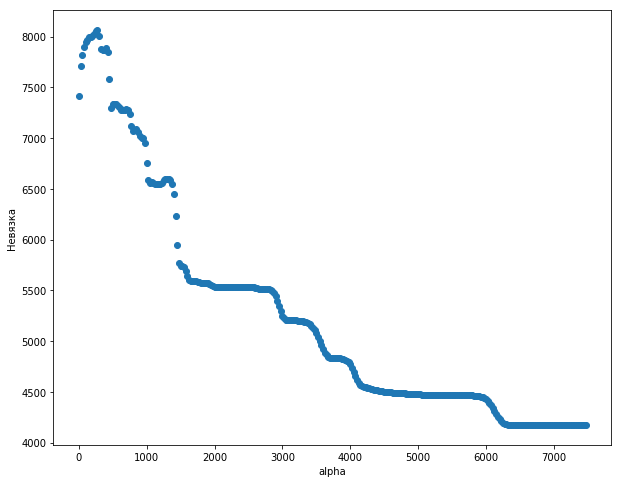

In [24]:
fig = plt.figure(figsize=(10, 8)) 
plt.scatter(alpha_range, er_list)
plt.ylabel('Невязка')
plt.xlabel('alpha')
plt.show()
fig.savefig('KEV_res/EMA' + str(len(alpha_range)) + '.png')

##### Best recovery corr matrix  

In [25]:
for line in best_matrix:
    print(line)

[ 27.09687132  30.47050064   0.           0.02704176   0.02621504
  29.46755333   0.           0.02746034   0.          62.63684073
   0.02621581  10.94833039  14.83376705  14.89646377   0.02610934
  12.62808472  13.33465379  12.61844577   0.02790875  20.62842872
  78.81186117  23.14134527 104.50649268  99.50465148  95.91915426
  91.7102287    0.02887294   0.02815576  87.87273327  35.81647825
  38.54347675  37.65639668  35.02878532   0.03102483  24.37604727
  42.99731578   9.069138     9.2117407    9.14274397   9.41418727
   0.0266219   58.16093882  19.23061587  19.15159587  18.95239871
  18.87573215   0.02692601 111.0552662    6.88534504  14.48497747
  14.83545433  58.98286064  31.3866826   66.22699418   3.83412613
   3.83412613  25.62170094   9.38935943  24.77487971  30.32468316
  16.08474225  12.57207752  13.07279519  12.57236785  13.11583999
  12.57236785  26.29806633   0.02609077  43.49131163   0.02655723
   0.02880182   0.02773731   0.02637736   0.02641834]
[18.04569755 20.292432

In [26]:
for line in correspondence_matrix:
    print(line)

[       nan  63.802849 471.81948         nan        nan        nan
 918.488499        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan  28.772957  31.681824        nan        nan
        nan        nan        nan        nan  29.681628   8.606275
   8.606275   8.606275   8.606275        nan        nan  11.722161
  20.428002  20.428002  20.428002  20.428002        nan  23.394305
        nan        nan        nan        nan        nan  14.575279
   8.505481   9.077854   9.077854   4.484028   4.452338   1.875118
        nan        nan        nan        nan   2.02354    2.02354
   1.880171   1.93676    1.93676    1.93676    1.93676    1.93676
   1.948398        nan   1.965538        nan        nan        nan
        nan        nan]
[ 44.610847        nan 118.65221         nan        nan 381.411877
        nan        nan        nan 167.195351        nan        nan
 104.283571 104.283571        nan  90.95

##### Multi-stage

In [66]:
def matrix_to_dict(corr_matrix):
    d = {}
    list_of_dict = []
    n = np.shape(corr_matrix)[0]
    buf_l = []
    buf_ind = []
    for i in range(1, n + 1):
        
        for j in range(1, n + 1):
            buf_ind.append(int(j))
            buf_l.append(float(corr_matrix[i-1][j-1]))
            
        if i in d:
            d[i].append(dict(zip(buf_ind, buf_l)))
        else:
            d[i] = dict(zip(buf_ind, buf_l))
            
        buf_ind = []
        buf_l = []
    
#     print(list_of_dict)
    return d

In [69]:
best_correcpondences_dict = matrix_to_dict(best_matrix)

In [70]:
model = md.Model(graph_data, best_correcpondences_dict, 
                 total_od_flow, mu = 0, rho = 0.15)

In [77]:
for i, eps_abs in enumerate(np.logspace(1,3,1)):
    print(i, eps_abs)

0 10.0


In [78]:
max_iter = 10000

for i, eps_abs in enumerate(np.logspace(1,3,1)):
    
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustf', 
                                    solver_kwargs = solver_kwargs, 
                                    verbose = False)

eps_abs = 10.0


/usr/local/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pred_edges' of function 'get_flows'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "oracles.py", line 26:
@njit
def get_flows(nodes_number, edges_number, targets, target_flows, pred_arr, pred_edges, sorted_vertices):  
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sorted_vertices' of function 'get_flows'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "oracles.py"

In [80]:
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
    
print('Time ratio =', np.max(result
                                ['times'] / graph_data['graph_table']
                                ['Free Flow Time']))
print('Flow excess =', np.max(result
                                ['flows'] / graph_data['graph_table']
                                ['Capacity']) - 1, end = '\n\n')

Elapsed time: 5114 sec
Time ratio = 4.262783922697723
Flow excess = 11.702861960906207



In [82]:
result['times']

array([0.238965  , 0.240297  , 0.222813  , 0.21890201, 0.40204599,
       0.46629983, 0.13150389, 0.20411362, 0.109499  , 0.11566526,
       0.39634139, 0.346955  , 0.1961374 , 0.20934081, 0.089394  ,
       0.09342793, 0.15102001, 0.148699  , 0.38412987, 0.44615303,
       0.14804396, 0.16481627, 0.456254  , 0.55995656, 0.3898707 ,
       0.47637105, 0.105565  , 0.19816937, 0.15049037, 0.092749  ,
       0.085073  , 0.25557109, 0.27569937, 0.42801091, 0.26500014,
       0.27332717, 0.1518012 , 0.1977666 , 0.06899264, 0.03138745,
       0.21106653, 0.20697154, 0.166898  , 0.23079776, 0.41117175,
       0.49118078, 0.1450872 , 0.20893415, 0.28587499, 0.29653201,
       0.101234  , 0.105394  , 0.152652  , 0.15131552, 0.021253  ,
       0.022086  , 0.068955  , 0.069246  , 0.048602  , 0.11301716,
       0.17399199, 0.16739   , 0.035226  , 0.055958  , 0.079145  ,
       0.079639  , 0.181953  , 0.177751  , 0.29871801, 0.28060299,
       0.185326  , 0.187372  , 0.187847  , 0.22313256, 0.10546